## Orders

In [2]:
import pandas as pd

df_orders = pd.read_csv("/Users/aliyadavletshina/Desktop/python_projects/df_orders")
df_orders.head()

,Unnamed: 0,id,user_id,total_cost,cost,item_total,promo_total,total_weight,total_quantity,state,shipped_at,created_at,ship_address_id,store_id,delivery_window_id
0,0,3158715,61138,290.0,290.0,2543,0.0,89906,35,shipped,2018-01-05 10:50:00,2018-01-05 00:07:04,448086,2,75258.0
1,1,3182881,73307,190.0,190.0,6076,0.0,30275,52,shipped,2018-01-06 15:33:54,2018-01-05 02:04:42,450946,10,75860.0
2,2,3146329,75386,290.0,290.0,2617,0.0,93040,24,shipped,2018-01-11 06:40:38,2018-01-05 02:07:35,458911,14,78635.0
3,3,3150465,45970,290.0,290.0,3422,0.0,10518,23,shipped,2018-01-06 12:55:22,2018-01-05 02:15:15,448101,21,75403.0
4,4,3169087,49089,90.0,90.0,3666,0.0,22740,31,shipped,2018-01-06 16:17:27,2018-01-05 02:48:52,451302,3,75825.0


In [3]:
def dropcol(df):
    try:
        return df.drop('Unnamed: 0', axis=1)
    except KeyError:
        return df

# df_orders[df_orders.isna().any(axis=1)]
df_orders = dropcol(df_orders)

### dates orders created

In [4]:
df_orders['created_at'].describe()

count                  334245
unique                 332305
top       2019-08-02 14:12:29
freq                        3
Name: created_at, dtype: object

In [5]:
from datetime import datetime as dt

def to_date(df, var):
    df[var] = pd.to_datetime(df[var])
for col in df_orders.filter(like='_at', axis=1).columns:
    to_date(df_orders, col)

In [6]:
df_orders.groupby(['user_id'])['id'].count().describe()

count    119031.000000
mean          2.808050
std           6.459847
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         475.000000
Name: id, dtype: float64

In [7]:
multiple_orders = df_orders.groupby(['user_id'])['id'].count().reset_index()
multiple_orders = multiple_orders[multiple_orders['id'] > 1]
print(multiple_orders.id.describe(), '\n mode', multiple_orders.id.mode())

count    43442.000000
mean         5.954054
std          9.937551
min          2.000000
25%          2.000000
50%          3.000000
75%          6.000000
max        475.000000
Name: id, dtype: float64 
 mode 0    2
dtype: int64


In [8]:
print(round((len(multiple_orders)*100/ len(df_orders.user_id)),1), '% клиентов сделали повторный заказ за период c 5 мая 2018 по 4 августа 2019 года.')
print('Кол-во повторных заказов чаще всего не превышало двух.')

13.0 % клиентов сделали повторный заказ за период c 5 мая 2018 по 4 августа 2019 года.
Кол-во повторных заказов чаще всего не превышало двух.


In [9]:
# cust_lifetime = df_orders.groupby(['user_id']).agg({'created_at':['min','max']}).sort_values(('created_at','min'), ascending=True).xs('created_at', axis=1, drop_level=True).reset_index()
# cust_lifetime['lifetime'] = cust_lifetime['max'] - cust_lifetime['min']
# cust_lifetime['lifetime'] = cust_lifetime['lifetime'].dt.days

# cust_lifetime['min'] = cust_lifetime['min'].dt.strftime('%Y-%m-%d')
# cust_lifetime['max'] = cust_lifetime['max'].dt.strftime('%Y-%m-%d')
# cust_lifetime

### Динамика по месяцам

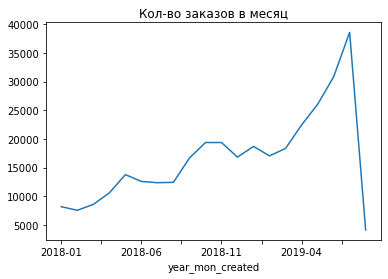

In [10]:
from matplotlib import pyplot as plt

# number of orders per month
df_orders['year_mon_created'] = df_orders['created_at'].dt.strftime('%Y-%m')
df_orders.groupby('year_mon_created')['id'].count().plot(title = "Кол-во заказов в месяц")

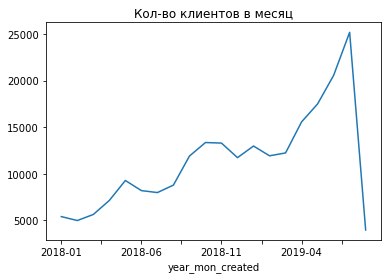

In [11]:
# number of unique customers per month
df_orders.groupby('year_mon_created')['user_id'].nunique().plot(title = "Кол-во клиентов в месяц")

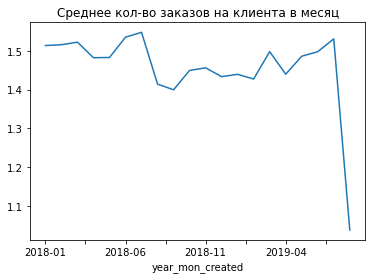

In [12]:
# average number of orders per customer per month 
avg_orders_per_customer = df_orders.groupby(['year_mon_created','user_id'])['id'].count().reset_index()
avg_orders_per_customer.groupby('year_mon_created')['id'].mean().plot(title = "Среднее кол-во заказов на клиента в месяц")

(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.]),
 <a list of 9 Text major ticklabel objects>)

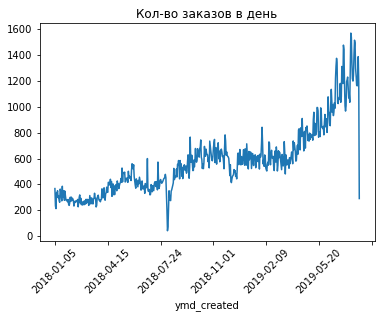

In [13]:
df_orders['ymd_created'] = df_orders['created_at'].dt.strftime('%Y-%m-%d')
df_orders.groupby(['ymd_created']).id.count().plot(title = "Кол-во заказов в день")
plt.xticks(rotation=45)

По основным показателям спроса наблюдается положительная динамика. 

In [14]:
import numpy as np

# find the lag between first and second order for each customer
grouped_df =  df_orders.groupby(['user_id'])['created_at']
orders_lag = pd.DataFrame(grouped_df.nth([0,1])).reset_index()
orders_lag = orders_lag[orders_lag['user_id'].isin(orders_lag['user_id'].value_counts()[orders_lag['user_id'].value_counts()>1].index)]
orders_lag = orders_lag.sort_values(['user_id','created_at'])
orders_lag['diffs'] = np.where(orders_lag.user_id == orders_lag.user_id.shift(1), orders_lag.created_at.diff(), 0)
orders_lag = orders_lag[1::2]
orders_lag['diff_days'] = orders_lag['diffs'].dt.days

orders_lag['year_mon'] = orders_lag['created_at'].dt.strftime('%Y-%m')

/Users/aliyadavletshina/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:177: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


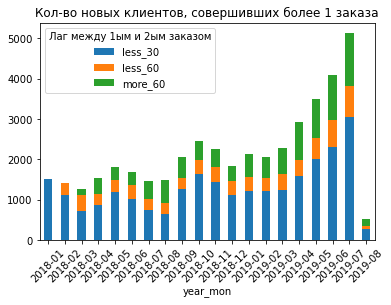

In [15]:
orders_lag['less_30'] = orders_lag.diffs.dt.days < 30
orders_lag['less_60'] = (orders_lag.diffs.dt.days < 60)*(orders_lag.diffs.dt.days >=30)
orders_lag['more_60'] = orders_lag.diffs.dt.days >= 60
orders_lag.drop_duplicates(['user_id','year_mon']).groupby(['year_mon'])[['less_30','less_60','more_60']].agg('sum').plot.bar(rot=0, stacked=True, title='Кол-во новых клиентов, совершивших более 1 заказа')
plt.xticks(rotation=45)
plt.legend(title='Лаг между 1ым и 2ым заказом')

С начала 2019 года наблюдается рост числа новых клиентов, совершивших как минимум один повторный заказ. 

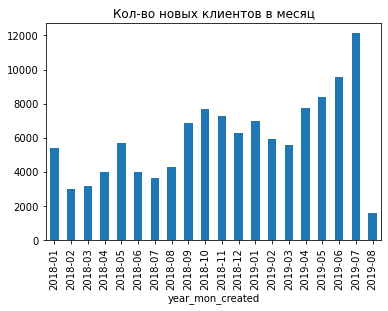

In [16]:
grouped_df =  df_orders.groupby(['user_id'])['year_mon_created']
pd.DataFrame(grouped_df.nth([0])).reset_index().groupby('year_mon_created').user_id.count().plot.bar(title='Кол-во новых клиентов в месяц')

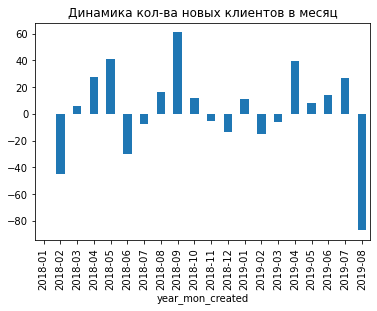

In [17]:
new_users = pd.DataFrame(grouped_df.nth([0]).reset_index().groupby('year_mon_created').user_id.count())
new_users['dynamics'] = round(((new_users['user_id']-new_users['user_id'].shift(1))*100 / new_users['user_id'].shift(1)), 2)
new_users.dynamics.plot.bar(title='Динамика кол-ва новых клиентов в месяц')

С марта 2019 года кол-во новых клиентов увеличивается. 

Среднее время между первым и вторым заказом продолжает увеличиваться.


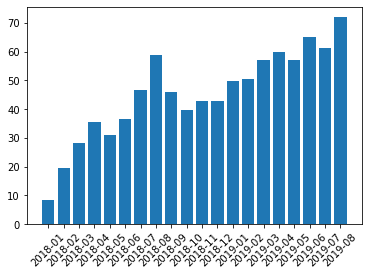

In [18]:
plt.bar(orders_lag.year_mon.sort_values().unique(), orders_lag.groupby('year_mon').diff_days.mean())
plt.xticks(rotation=45)
print('Среднее время между первым и вторым заказом продолжает увеличиваться.')

### Динамика по дням

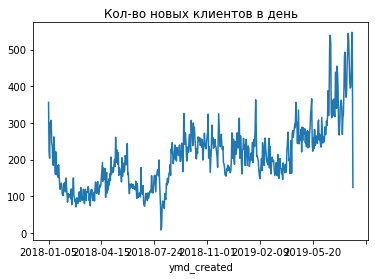

In [19]:
grouped_df =  df_orders.groupby(['user_id'])['ymd_created']
pd.DataFrame(grouped_df.nth([0])).reset_index().groupby('ymd_created').user_id.count().plot(title='Кол-во новых клиентов в день')

Наблюдается положительная динамика по кол-ву новых клиентов в день. 

### Average receipt

In [20]:
import seaborn as sns

# sns.distplot(df_orders.groupby('user_id').item_total.mean())

(4400.0, 5800.0)

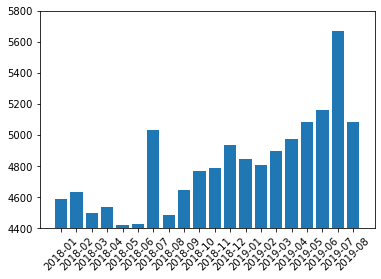

In [21]:
plt.bar(df_orders.year_mon_created.unique(), df_orders.groupby('year_mon_created').item_total.mean())
plt.xticks(rotation=45)
plt.ylim((4400,5800))

Средний чек стремительно растет начиная с февраля 2019 года. 

In [22]:
df_orders.item_total.describe()

count    334245.000000
mean       4917.515152
std        5526.465519
min           0.000000
25%        2566.000000
50%        3873.000000
75%        5806.000000
max      480746.000000
Name: item_total, dtype: float64

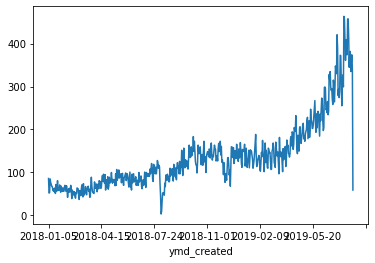

In [23]:
df_expensive_orders = df_orders[df_orders.item_total > 6000]
df_expensive_orders.groupby('ymd_created').id.count().plot()

Количество "дорогих" заказов (свыше 6000 руб.) повторяет общую динамику заказов. 

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

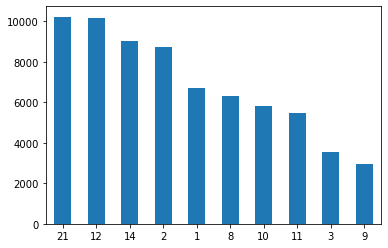

In [24]:
df_expensive_orders.store_id.value_counts().head(10).plot.bar()
plt.xticks(rotation=0)

Наибольший средний чек в магазинах 21, 12, 14. 

## Deliveries

In [25]:
df_delivery_windows = pd.read_csv("/Users/aliyadavletshina/Desktop/python_projects/df_delivery_windows")
df_delivery_windows = df_delivery_windows.rename({'id':'delivery_window_id'}, axis=1)
df_delivery_windows = dropcol(df_delivery_windows)
df_delivery_windows = df_delivery_windows.drop_duplicates()

In [26]:
df_orders_delivery = df_delivery_windows.iloc[:,1:4].set_index('delivery_window_id').join(df_orders.set_index('delivery_window_id'), how='inner')
print(len(df_orders_delivery), df_orders_delivery.duplicated().sum(), len(df_orders))

334244 0 334245


In [27]:
for col in df_orders_delivery.filter(like='_at', axis=1).columns:
    to_date(df_orders_delivery, col)

In [28]:
df_orders_delivery['delivery_duration'] = df_orders_delivery.ends_at - df_orders_delivery.starts_at
print('average delivery time: ', str(df_orders_delivery['delivery_duration'].mean())[7:15])
print('max delivery time: ', str(df_orders_delivery['delivery_duration'].max())[7:15])
print('min delivery time: ', str(df_orders_delivery['delivery_duration'].min())[7:15])

average delivery time:  02:05:39
max delivery time:  11:00:00
min delivery time:  00:30:00


In [29]:
df_orders_delivery.delivery_duration = df_orders_delivery.delivery_duration.dt.seconds // 60
# df_orders_delivery.columns

In [30]:
from sklearn.preprocessing import StandardScaler

min_max_scaler = StandardScaler()
df_orders_delivery_std = df_orders_delivery.copy()
df_orders_delivery_std.loc[:, 'total_cost':'total_quantity'] = min_max_scaler.fit_transform(df_orders_delivery_std.loc[:, 'total_cost':'total_quantity'])
# df_orders_delivery_std

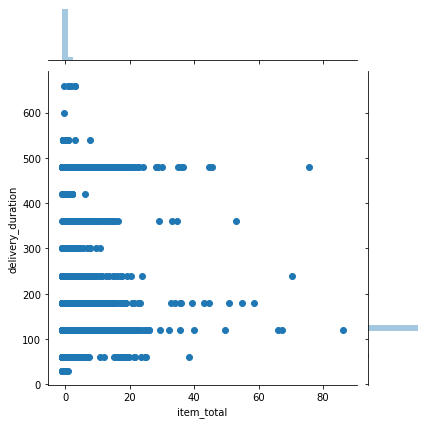

In [31]:
sns.jointplot(df_orders_delivery_std.item_total, df_orders_delivery_std.delivery_duration)
# plt.scatter(df_orders_delivery['items_total']

In [32]:
df_orders_delivery['create_ship_lag'] = df_orders_delivery['shipped_at'] - df_orders_delivery['created_at']
df_orders_delivery.create_ship_lag.describe()

count                     334244
mean      4 days 04:05:41.360942
std      16 days 17:10:47.738271
min            -3 days +00:02:25
25%       0 days 09:53:14.750000
50%              0 days 21:42:24
75%       1 days 21:44:32.250000
max            515 days 01:31:12
Name: create_ship_lag, dtype: object

Распределение времени сбора заказа (в днях) для заказов, которые были отправлены более чем через 16 дней после создания заказа.


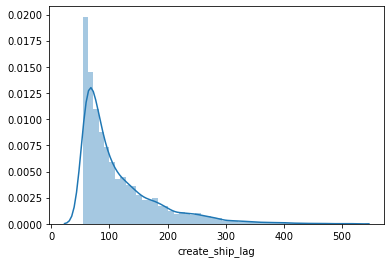

In [33]:
print(f"Распределение времени сбора заказа (в днях) для заказов, которые были отправлены более чем через {int(df_orders_delivery.create_ship_lag.dt.days.std())} дней после создания заказа.")
sns.distplot(df_orders_delivery[(df_orders_delivery.create_ship_lag - df_orders_delivery.create_ship_lag.mean()) > df_orders_delivery.create_ship_lag.std()*3].create_ship_lag.dt.days)
# df_orders_delivery[df_orders_delivery.create_ship_lag.dt.days > 14].create_ship_lag.std()

In [34]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(df_orders_delivery.loc[:, 'total_cost':'total_quantity'], df_orders_delivery_std.delivery_duration)
# print('Coefficients: \n', model.coef_)
pd.DataFrame({'regressor':['total_cost',
       'cost', 'item_total', 'promo_total', 'total_weight', 'total_quantity'], 'coef':model.coef_})

,regressor,coef
0,total_cost,-0.010413
1,cost,0.053224
2,item_total,0.000277
3,promo_total,-0.001697
4,total_weight,0.000208
5,total_quantity,0.004717


## Cancellations and replacements

In [38]:
df_replace = pd.read_csv("/Users/aliyadavletshina/Desktop/python_projects/df_replacements")
df_cancel = pd.read_csv("/Users/aliyadavletshina/Desktop/python_projects/df_cancellations")
df_replace = dropcol(df_replace)
df_cancel = dropcol(df_cancel)
print(df_replace[df_replace.isna().any(axis=1)])
df_cancel[df_cancel.isna().any(axis=1)]

Empty DataFrame
Columns: [order_id, item_id, state]
Index: []


,order_id,item_id,state


In [39]:
df_cancel = df_cancel.drop_duplicates()
df_replace = df_replace.drop_duplicates()
df_replace = dropcol(df_replace)
df_cancel = dropcol(df_cancel)
# df_orders_delivery_std = dropcol(df_orders_delivery_std)
df_orders_delivery = dropcol(df_orders_delivery)

In [40]:
# get length of dataframes 
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name
    
def printlen(df):
    print('Length of', get_df_name(df), len(df))

dfs = [df_cancel,df_delivery_windows, df_expensive_orders, df_orders, df_orders_delivery, df_replace]
for table in dfs:
    printlen(table)

Length of df_cancel 507119
Length of df_delivery_windows 137498
Length of df_expensive_orders 77956
Length of df_orders 334245
Length of df_orders_delivery 334244
Length of df_replace 328142


In [41]:
# find the number of duplicates 
def find_duplicates(df):
    print(get_df_name(df), df.duplicated().sum())
for table in dfs:
    find_duplicates(table)

df_cancel 0
df_delivery_windows 0
df_expensive_orders 0
df_orders 0
df_orders_delivery 0
df_replace 0


In [42]:
stores_replace = df_orders_delivery[df_orders_delivery.id.isin(df_replace.order_id)].store_id.value_counts().reset_index().rename({'index':'store_id', 'store_id':'num_replaced'}, axis=1)
all_stores = df_orders_delivery.store_id.value_counts().reset_index().rename({'index':'store_id', 'store_id':'num_orders'}, axis=1)
stores_orders = all_stores.set_index('store_id').join(stores_replace.set_index('store_id'))
stores_orders['replace_rate'] = stores_orders.num_replaced * 100 // stores_orders.num_orders
print('Средняя по всем магазинам доля заказов, в которых производится замена продукта - ', round(stores_orders.replace_rate.mean(),2), '%')
stores_orders.sort_values(['num_orders','replace_rate'], ascending=False).head(10)

Средняя по всем магазинам доля заказов, в которых производится замена продукта -  50.48 %


,num_orders,num_replaced,replace_rate
store_id,,,
14,34741,14786,42
2,34538,14115,40
12,34334,15073,43
21,33379,14796,44
8,28277,12486,44
1,26759,11805,44
10,22914,10184,44
11,21431,9967,46
3,19417,7627,39


<ipython-input-43-74fe78172ef0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_orders_delivery_std['replaced'][np.array(df_orders_delivery_std.id.isin(df_replace.order_id))] = 1


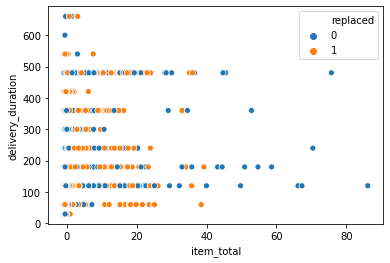

In [43]:
df_orders_delivery_std['replaced'] = np.zeros(len(df_orders_delivery_std), dtype=np.int8)
df_orders_delivery_std['replaced'][np.array(df_orders_delivery_std.id.isin(df_replace.order_id))] = 1

sns.scatterplot(df_orders_delivery_std.item_total, df_orders_delivery_std.delivery_duration, hue=df_orders_delivery_std.replaced)

Нет ярко выраженной зависимости длительности доставки от замены товаров в заказе. 

In [44]:
# check how repeated purchase depends on delivery time

stores_cancel = df_orders_delivery[df_orders_delivery.id.isin(df_cancel.order_id)].store_id.value_counts().reset_index().rename({'index':'store_id', 'store_id':'num_cancelled'}, axis=1)

stores_cancel = all_stores.set_index('store_id').join(stores_cancel.set_index('store_id'))
stores_cancel['cancel_rate'] = stores_cancel.num_cancelled * 100 // stores_cancel.num_orders
print('Средняя по всем магазинам доля отмененных заказов - ', round(stores_cancel.cancel_rate.mean(),2), '%')
stores_cancel.sort_values(['num_orders','cancel_rate'], ascending=False).head(10)

Средняя по всем магазинам доля отмененных заказов -  57.03 %


,num_orders,num_cancelled,cancel_rate
store_id,,,
14,34741,20007,57
2,34538,18786,54
12,34334,17030,49
21,33379,18064,54
8,28277,16387,57
1,26759,15171,56
10,22914,13192,57
11,21431,13064,60
3,19417,11793,60


In [45]:
print(round(df_replace[df_replace.order_id.isin(df_cancel.order_id)]['order_id'].nunique()*100 / df_replace.order_id.nunique(), 2), '% заказов, в которых производилась замена продукта, были отменены.')

66.0 % заказов, в которых производилась замена продукта, были отменены.


In [46]:
df_orders_delivery[df_orders_delivery.id.isin(df_cancel.order_id)].state.unique()

array(['shipped', 'pending', 'canceled'], dtype=object)

Среди заказов, которые были отменены (хранящиеся в таблице df_cancel), есть те, которые были отправлены, т.е. их статус в таблице df_orders отмечен как `shipped`. 

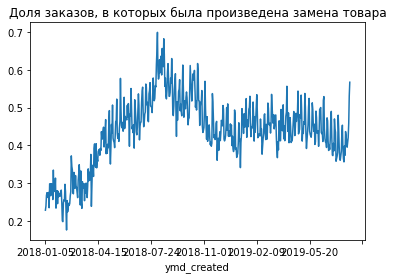

In [47]:
(df_orders_delivery_std.groupby('ymd_created').replaced.sum()/df_orders_delivery_std.groupby('ymd_created').replaced.count()).plot(title='Доля заказов, в которых была произведена замена товара')

In [49]:
(df_orders_delivery_std.groupby('ymd_created').canceled.sum()/df_orders_delivery_std.groupby('ymd_created').canceled.count()).plot(title='Доля отмененных заказов')

AttributeError: 'DataFrameGroupBy' object has no attribute 'cancelled'

In [ ]:
Доля отмененных заказов снижается. 

<ipython-input-50-2155f5b67c27>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_orders_delivery_std['canceled'][np.array(df_orders_delivery_std.id.isin(df_cancel.order_id))] = 1


(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35.]),
 <a list of 9 Text major ticklabel objects>)

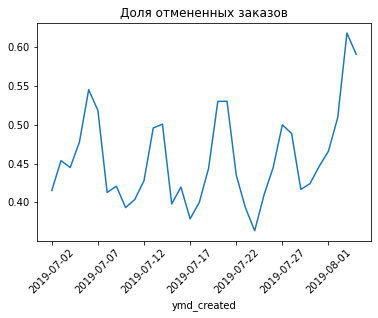

In [50]:
df_orders_delivery_std['canceled'] = np.zeros(len(df_orders_delivery_std), dtype=np.int8)
df_orders_delivery_std['canceled'][np.array(df_orders_delivery_std.id.isin(df_cancel.order_id))] = 1
(df_orders_delivery_std[df_orders_delivery_std.ymd_created > '2019-07-01'].groupby('ymd_created').canceled.sum()/df_orders_delivery_std[df_orders_delivery_std.ymd_created > '2019-07-01'].groupby('ymd_created').canceled.count()).plot(title='Доля отмененных заказов')
plt.xticks(rotation=45)

(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35.]),
 <a list of 9 Text major ticklabel objects>)

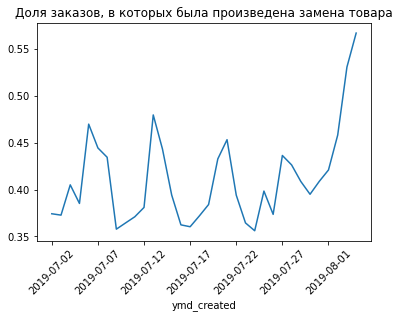

In [51]:
(df_orders_delivery_std[df_orders_delivery_std.ymd_created > '2019-07-01'].groupby('ymd_created').replaced.sum()/df_orders_delivery_std[df_orders_delivery_std.ymd_created > '2019-07-01'].groupby('ymd_created').replaced.count()).plot(title='Доля заказов, в которых была произведена замена товара')
plt.xticks(rotation=45)

In [ ]:
Динамика доли отменненных заказов имеет постоянную вариацию. Колебания могут зависеть от дня недели. Начиная с последнего месяца, августа, наблюдается рост числа замен продуктов и, соотвественно, рост доли отменных заказов (в день).